# Housing Price Prediction

This notebook attempts to predict housing prices using the Ames Housing dataset. To solve this problem, several steps are implemented.

    1. Check data for missing values and incorrect datatypes.
    2. Exploratory Data Analysis: Intuitively, we expect to observe relationships between house features and their prices.
    3. Final Dataframe Creation: Create any new features that could be more useful to the models accuracy.
    4. Transform Columns: Continuous variable standardization and categorical encoding.
    5. Model Testing: Check various regressor models and check accuracy with cross-validation. Hyperparameter tuning.
    6. Predict With Best Found Model
    7. Export Predictions

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)

## 1. Import Train Data, Check Data Types, Check Missing Values

In [2]:
data_dir = 'Data/'
df = pd.read_csv(f'{data_dir}train.csv', index_col = 'Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
### Check dataset dimensions
print(f'Rows: {df.shape[0]}\nColumns: {df.shape[1]}')

Rows: 1460
Columns: 80


In [4]:
### Check datatypes
df.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object


In [5]:
### Check for missing values
missing_values = df.isna().sum()
missing_df = pd.DataFrame(missing_values, columns = ['Missing Values'])
missing_df = missing_df.loc[missing_df['Missing Values'] > 0]
missing_df

,Missing Values
LotFrontage,259
Alley,1369
MasVnrType,8
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


Immediately, it is clear to ignore some columns with many missing values. Others will have to be filled.

## 2. Exploratory Data Analysis

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

###### Continuous Data

In [7]:
continuous_variables = ['SalePrice', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                        'GrLivArea', 'GarageArea', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'BedroomAbvGr',
                        '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'FullBath', 'HalfBath', 'TotRmsAbvGrd',
                        'KitchenAbvGr', 'Fireplaces']

df_cont = df[continuous_variables]

In [8]:
df_cont.describe()

,SalePrice,LotArea,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,GarageCars,...,BedroomAbvGr,3SsnPorch,ScreenPorch,PoolArea,MiscVal,FullBath,HalfBath,TotRmsAbvGrd,KitchenAbvGr,Fireplaces
count,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,180921.195890,10516.828082,103.685262,1057.429452,1162.626712,346.992466,5.844521,1515.463699,472.980137,1.767123,...,2.866438,3.409589,15.060959,2.758904,43.489041,1.565068,0.382877,6.517808,1.046575,0.613014
std,79442.502883,9981.264932,181.066207,438.705324,386.587738,436.528436,48.623081,525.480383,213.804841,0.747315,...,0.815778,29.317331,55.757415,40.177307,496.123024,0.550916,0.502885,1.625393,0.220338,0.644666
min,34900.000000,1300.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,129975.000000,7553.500000,0.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,334.500000,1.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000,1.000000,0.000000
50%,163000.000000,9478.500000,0.000000,991.500000,1087.000000,0.000000,0.000000,1464.000000,480.000000,2.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,6.000000,1.000000,1.000000
75%,214000.000000,11601.500000,166.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,576.000000,2.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,7.000000,1.000000,1.000000
max,755000.000000,215245.000000,1600.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,1418.000000,4.000000,...,8.000000,508.000000,480.000000,738.000000,15500.000000,3.000000,2.000000,14.000000,3.000000,3.000000


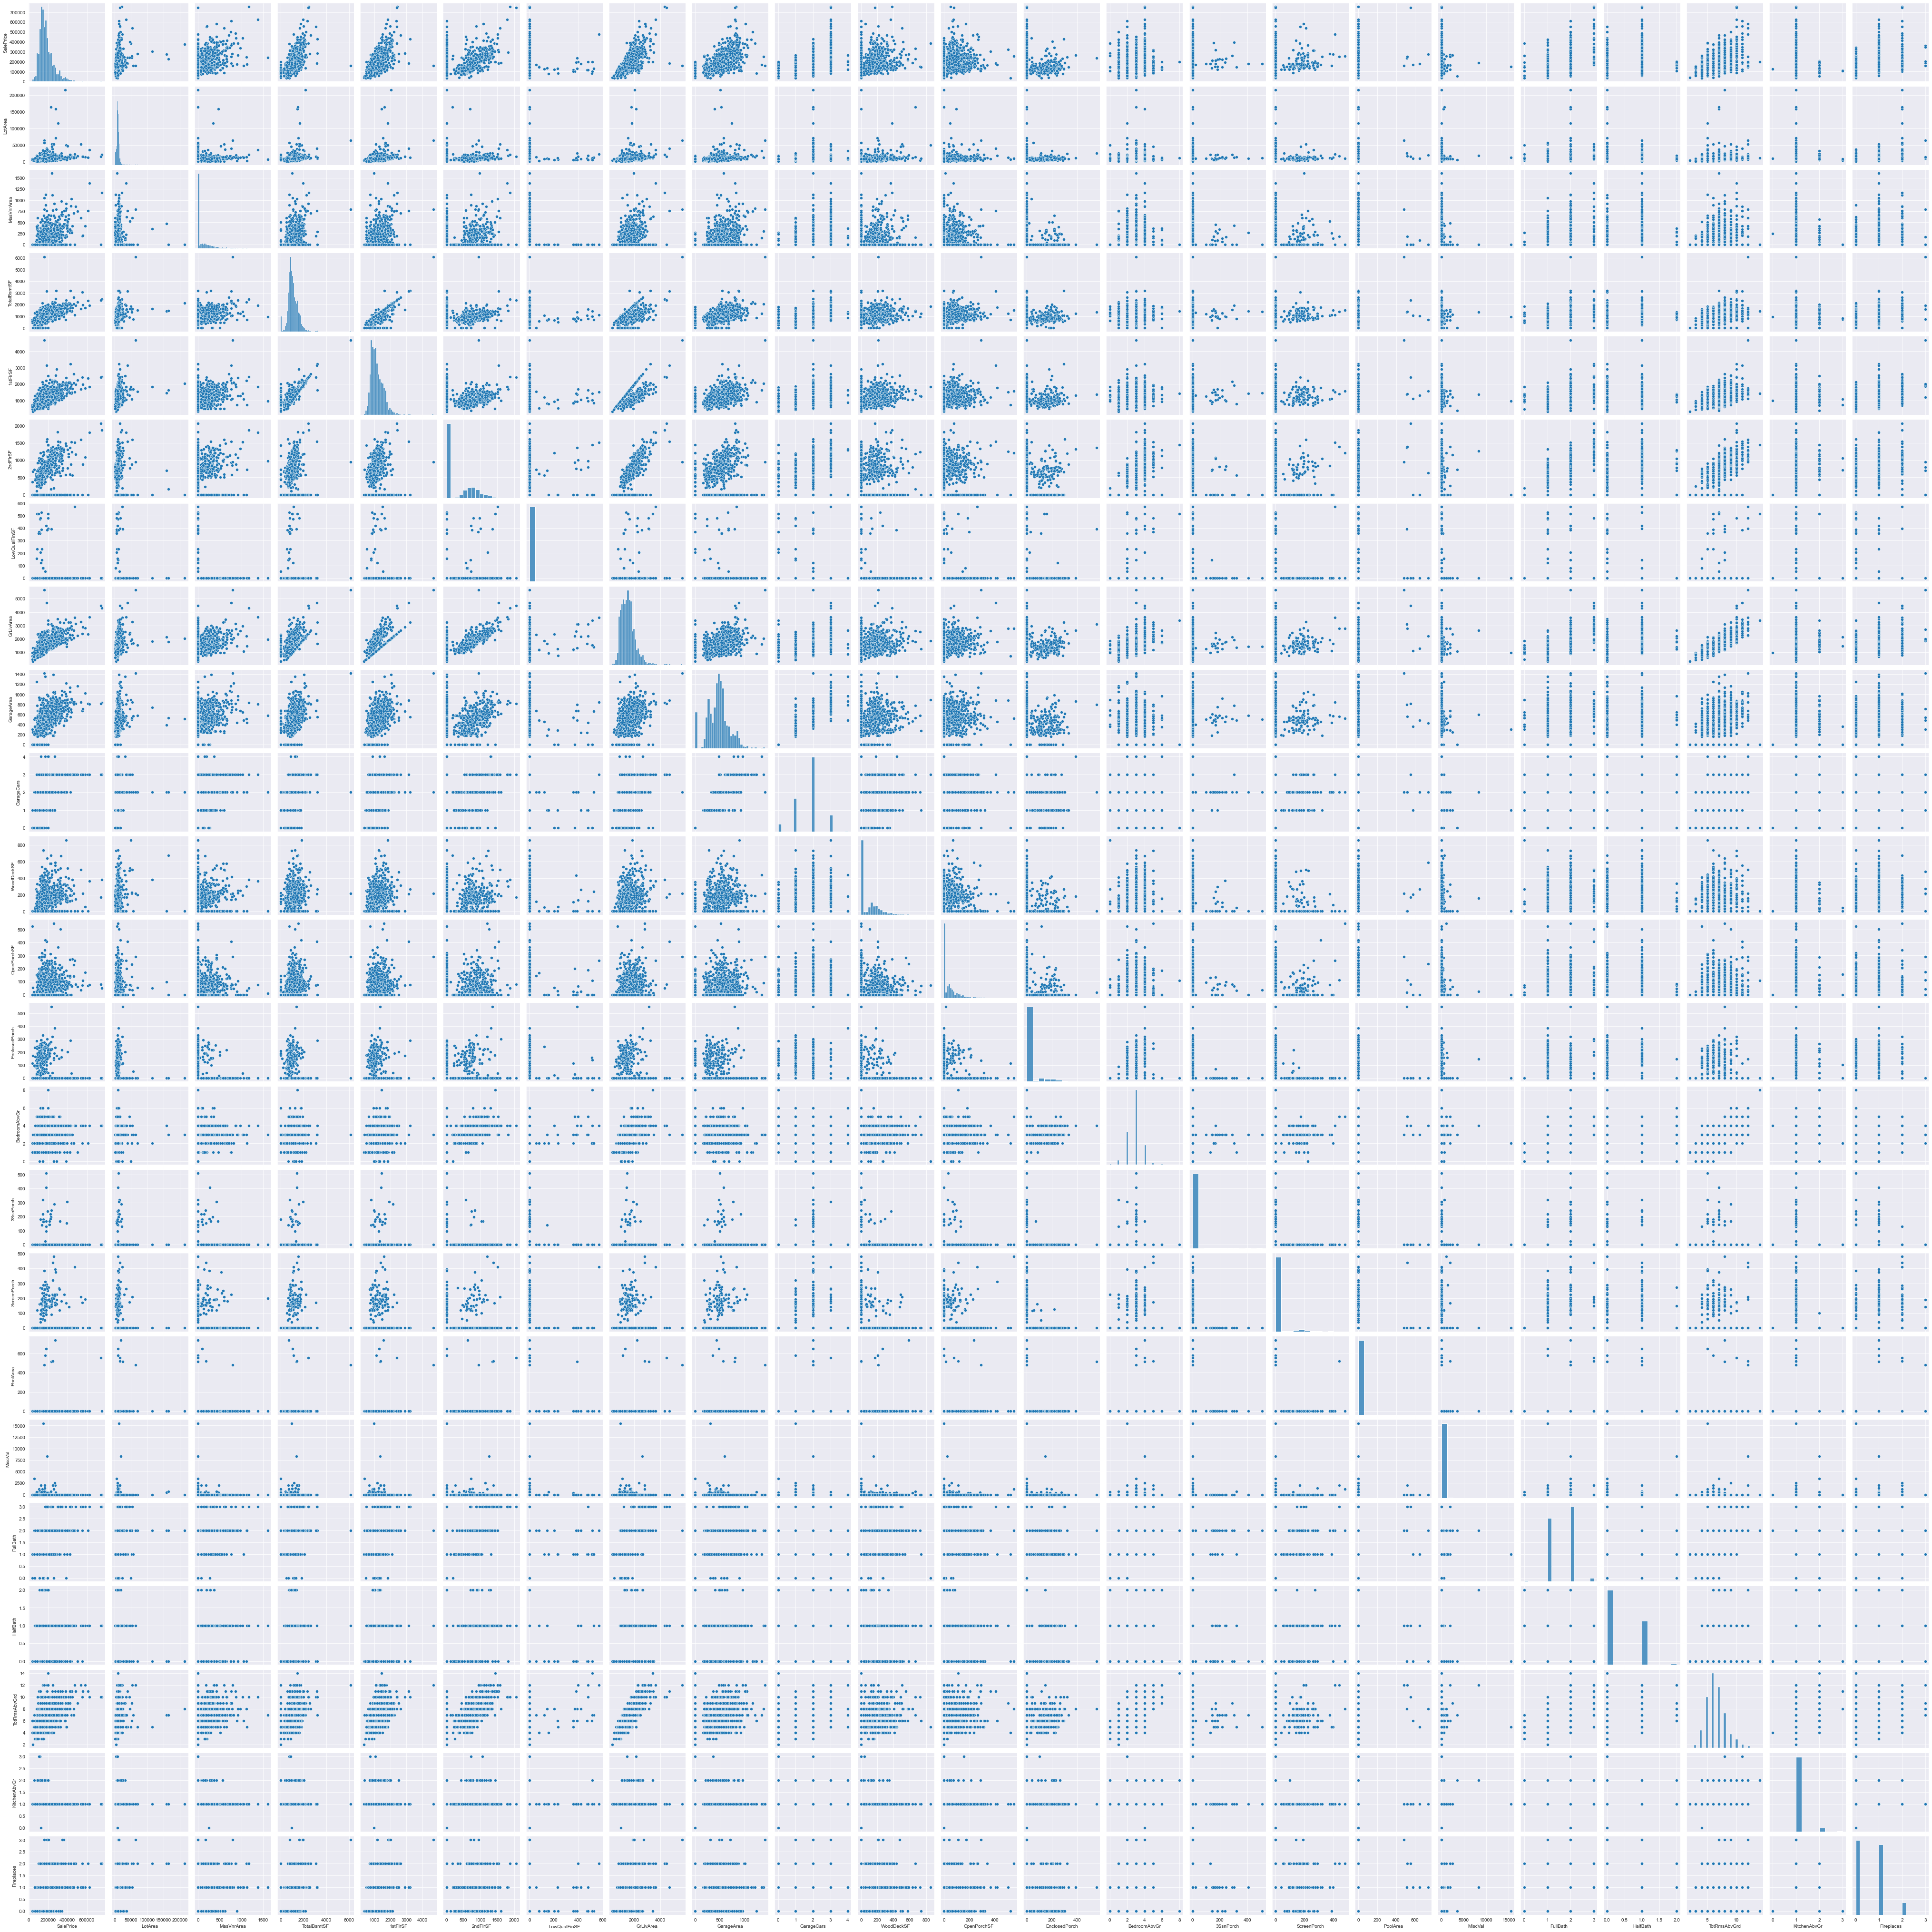

In [9]:
df_cont_corr = sns.pairplot(df_cont)

Clearly there are positive relationships between the variables -- TotalBsmtSF, GrLivArea, FullBath, and GarageCars -- and SalePrice. What additional variables could be constructed from the continuous data? 

    - The areas of extra features like pools and porches could be converted to binary variables. 
    - An indication of average room size could be useful.
    - Number of half baths seems less correlated to price than full baths. A combination of these variables could be best.

<ipython-input-10-9c6fbaa48bd6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cont['AvgRoomSize'] = df_cont['GrLivArea'] / df_cont['TotRmsAbvGrd']
<ipython-input-10-9c6fbaa48bd6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cont['TotBaths'] = df_cont['FullBath'] + (df_cont['HalfBath'] / 2)


<AxesSubplot:xlabel='TotBaths', ylabel='SalePrice'>

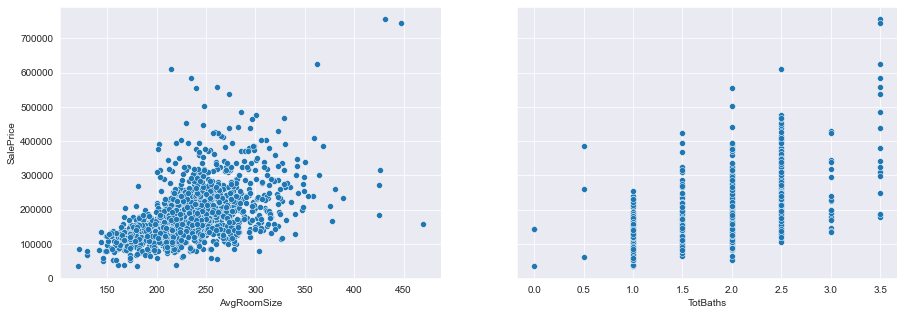

In [10]:
df_cont['AvgRoomSize'] = df_cont['GrLivArea'] / df_cont['TotRmsAbvGrd']
df_cont['TotBaths'] = df_cont['FullBath'] + (df_cont['HalfBath'] / 2)

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey = True)
sns.scatterplot(data = df_cont, x = 'AvgRoomSize', y = 'SalePrice',ax = ax[0])
sns.scatterplot(data = df_cont, x = 'TotBaths', y = 'SalePrice', ax = ax[1])

##### Binary Data

In [11]:
### Create Binary Variables
df_binary = pd.DataFrame()

df.loc[df['PoolArea'] > 0, 'HasPool'] = 1
df.loc[df['PoolArea'] == 0, 'HasPool'] = 0
df_binary['HasPool'] = df['HasPool']

df.loc[(df['ScreenPorch'] > 0) | (df['3SsnPorch'] > 0) | (df['EnclosedPorch'] > 0) | (df['OpenPorchSF']) | (df['WoodDeckSF'] > 0), 'HasPorch'] = 1
df.loc[df['HasPorch'] != 1, 'HasPorch'] = 0
df_binary['HasPorch'] = df['HasPorch']

df.loc[df['Street'] == 'Pave', 'IsPaved'] = 1
df.loc[df['Street'] != 'Pave', 'IsPaved'] = 0
df_binary['IsPaved'] = df['IsPaved']

df.loc[df['CentralAir'] == 'Y', 'HasAir'] = 1
df.loc[df['CentralAir'] != 'Y', 'HasAir'] = 0
df_binary['HasAir'] = df['HasAir']

df_binary['SalePrice'] = df['SalePrice']

<AxesSubplot:xlabel='HasAir', ylabel='SalePrice'>

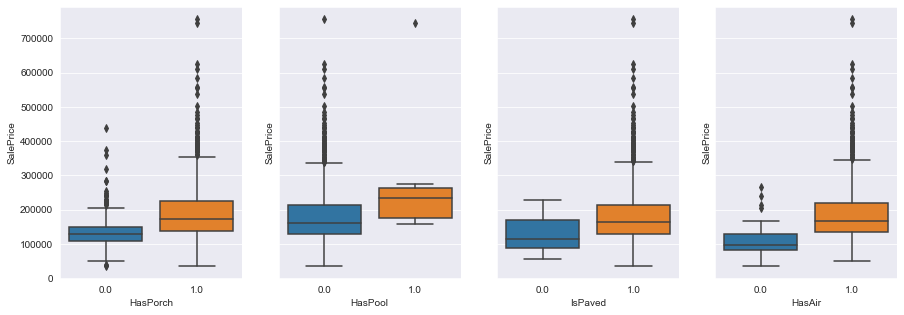

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5), sharey = True)
sns.boxplot(data = df_binary, x = 'HasPorch', y = 'SalePrice', ax = ax[0])
sns.boxplot(data = df_binary, x = 'HasPool', y = 'SalePrice', ax = ax[1])
sns.boxplot(data = df_binary, x = 'IsPaved', y = 'SalePrice', ax = ax[2])
sns.boxplot(data = df_binary, x = 'HasAir', y = 'SalePrice', ax = ax[3])

##### Non-ordinal Categorical Data

In [13]:
categorical_variables = ['SalePrice','MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
                         'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
                         'RoofMatl', 'Exterior1st', 'Foundation', 'BsmtFinType1', 'Heating', 'CentralAir',
                         'Electrical', 'MiscFeature']

df_cat = df[categorical_variables]

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

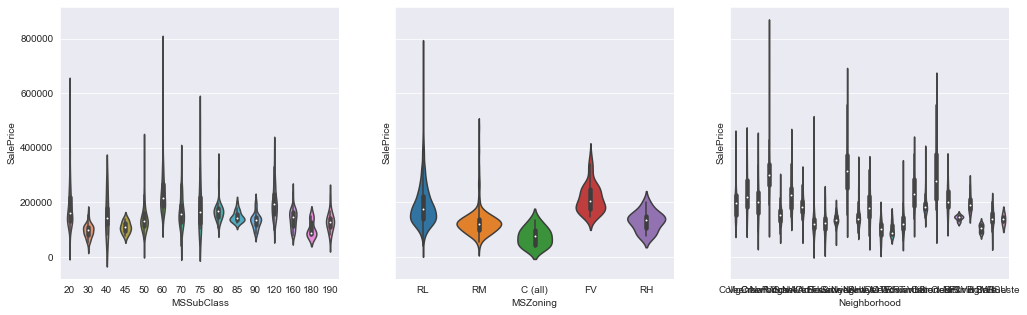

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5), sharey = True)
sns.violinplot(data = df_cat, x = 'MSSubClass', y = 'SalePrice', ax = ax[0])
sns.violinplot(data = df_cat, x = 'MSZoning', y = 'SalePrice', ax = ax[1])
sns.violinplot(data = df_cat, x = 'Neighborhood', y = 'SalePrice', ax = ax[2])

<AxesSubplot:xlabel='LotConfig', ylabel='SalePrice'>

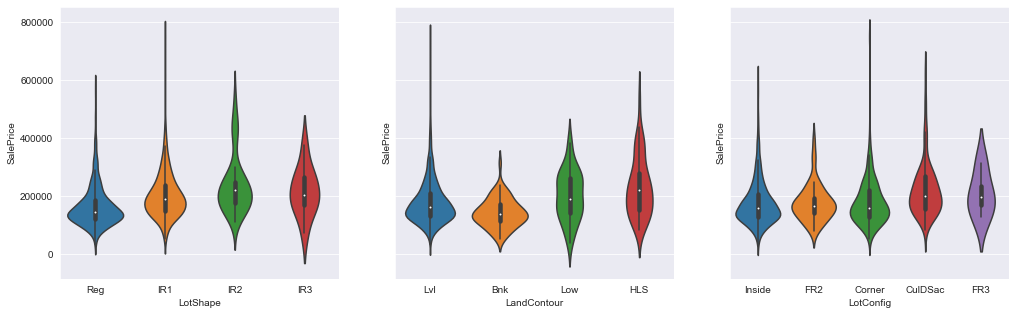

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5), sharey = True)
sns.violinplot(data = df_cat, x = 'LotShape', y = 'SalePrice', ax = ax[0])
sns.violinplot(data = df_cat, x = 'LandContour', y = 'SalePrice', ax = ax[1])
sns.violinplot(data = df_cat, x = 'LotConfig', y = 'SalePrice', ax = ax[2])

<AxesSubplot:xlabel='BldgType', ylabel='SalePrice'>

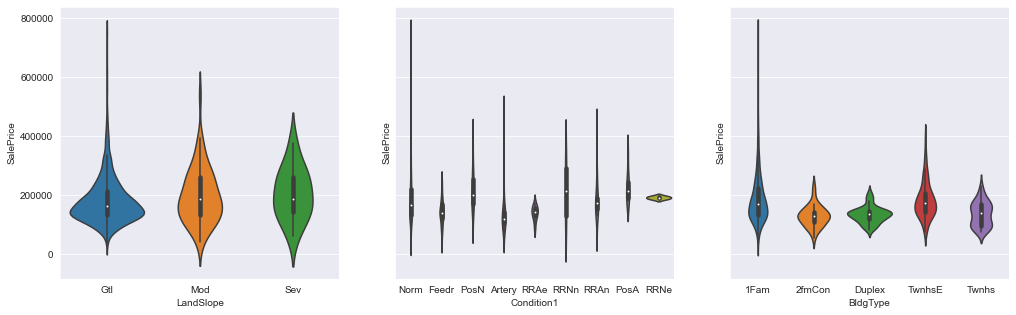

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5), sharey = True)
sns.violinplot(data = df_cat, x = 'LandSlope', y = 'SalePrice', ax = ax[0])
sns.violinplot(data = df_cat, x = 'Condition1', y = 'SalePrice', ax = ax[1])
sns.violinplot(data = df_cat, x = 'BldgType', y = 'SalePrice', ax = ax[2])

<AxesSubplot:xlabel='RoofStyle', ylabel='SalePrice'>

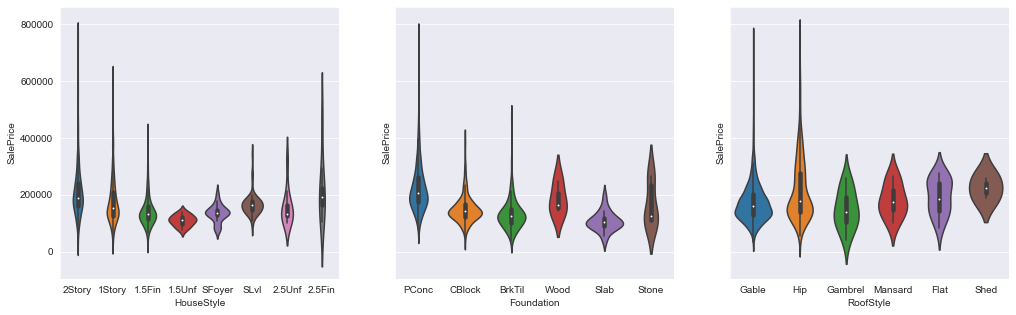

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5), sharey = True)
sns.violinplot(data = df_cat, x = 'HouseStyle', y = 'SalePrice', ax = ax[0])
sns.violinplot(data = df_cat, x = 'Foundation', y = 'SalePrice', ax = ax[1])
sns.violinplot(data = df_cat, x = 'RoofStyle', y = 'SalePrice', ax = ax[2])

<AxesSubplot:xlabel='BsmtFinType1', ylabel='SalePrice'>

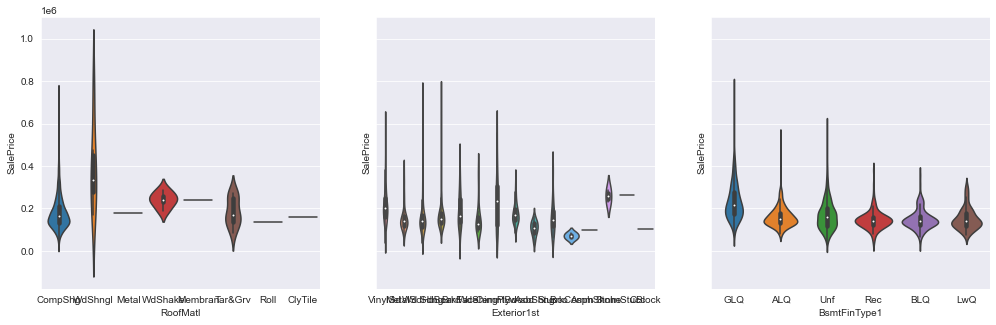

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5), sharey = True)
sns.violinplot(data = df_cat, x = 'RoofMatl', y = 'SalePrice', ax = ax[0])
sns.violinplot(data = df_cat, x = 'Exterior1st', y = 'SalePrice', ax = ax[1])
sns.violinplot(data = df_cat, x = 'BsmtFinType1', y = 'SalePrice', ax = ax[2])

<AxesSubplot:xlabel='Electrical', ylabel='SalePrice'>

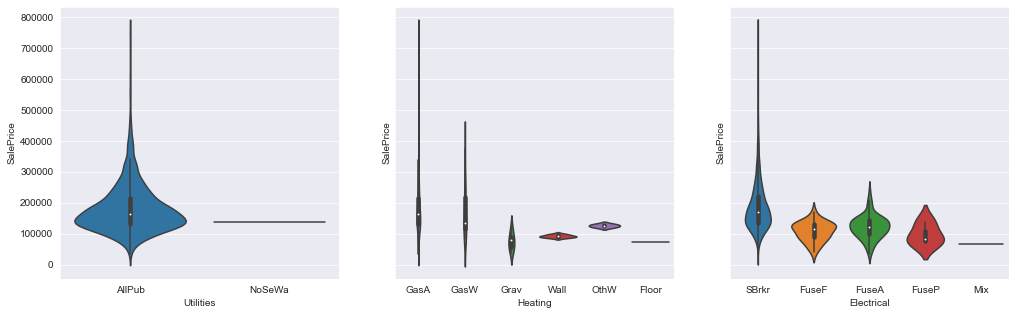

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5), sharey = True)
sns.violinplot(data = df_cat, x = 'Utilities', y = 'SalePrice', ax = ax[0])
sns.violinplot(data = df_cat, x = 'Heating', y = 'SalePrice', ax = ax[1])
sns.violinplot(data = df_cat, x = 'Electrical', y = 'SalePrice', ax = ax[2])

##### Ordinal Categorical Data

In [20]:
ordinal_variables = ['SalePrice', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                     'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond', 'PavedDrive', 'Functional']

df_ordinal = df[ordinal_variables]

<AxesSubplot:xlabel='Functional', ylabel='SalePrice'>

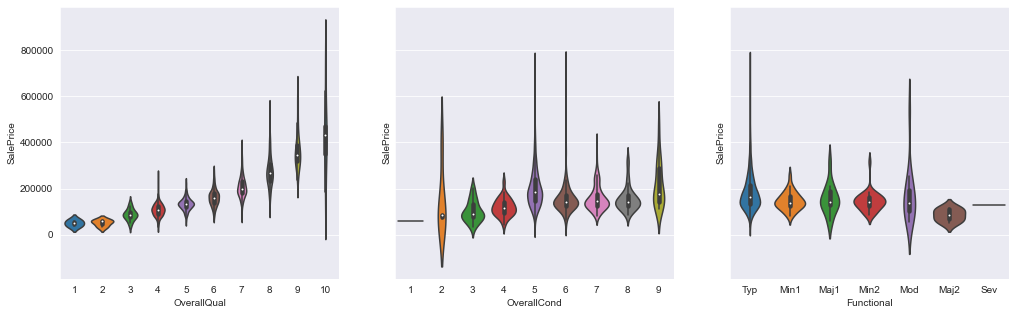

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5), sharey = True)
sns.violinplot(data = df_ordinal, x = 'OverallQual', y = 'SalePrice', ax = ax[0])
sns.violinplot(data = df_ordinal, x = 'OverallCond', y = 'SalePrice', ax = ax[1])
sns.violinplot(data = df_ordinal, x = 'Functional', y = 'SalePrice', ax = ax[2])

<AxesSubplot:xlabel='PavedDrive', ylabel='SalePrice'>

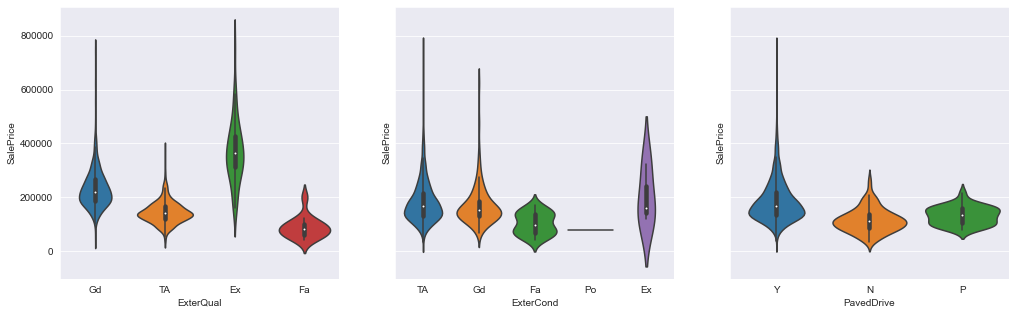

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5), sharey = True)
sns.violinplot(data = df_ordinal, x = 'ExterQual', y = 'SalePrice', ax = ax[0])
sns.violinplot(data = df_ordinal, x = 'ExterCond', y = 'SalePrice', ax = ax[1])
sns.violinplot(data = df_ordinal, x = 'PavedDrive', y = 'SalePrice', ax = ax[2])

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice'>

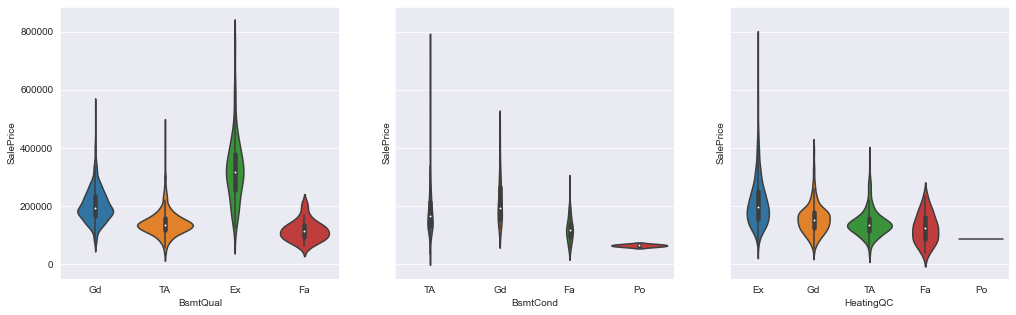

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5), sharey = True)
sns.violinplot(data = df_ordinal, x = 'BsmtQual', y = 'SalePrice', ax = ax[0])
sns.violinplot(data = df_ordinal, x = 'BsmtCond', y = 'SalePrice', ax = ax[1])
sns.violinplot(data = df_ordinal, x = 'HeatingQC', y = 'SalePrice', ax = ax[2])

<AxesSubplot:xlabel='GarageCond', ylabel='SalePrice'>

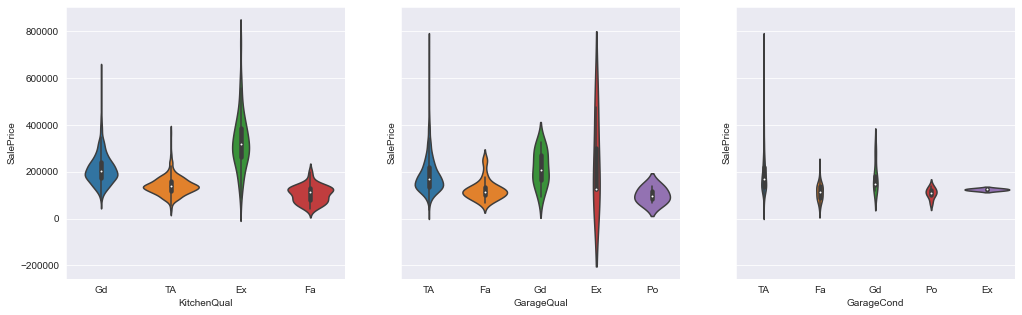

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5), sharey = True)
sns.violinplot(data = df_ordinal, x = 'KitchenQual', y = 'SalePrice', ax = ax[0])
sns.violinplot(data = df_ordinal, x = 'GarageQual', y = 'SalePrice', ax = ax[1])
sns.violinplot(data = df_ordinal, x = 'GarageCond', y = 'SalePrice', ax = ax[2])

##### Time Variables

The age of a house or its age since the last renovation could be associated with the price. Because the houses were sold at different times, the age should be calculated from that sale date.

In [25]:
time_variables = ['SalePrice', 'YearBuilt', 'YearRemodAdd', 'YrSold']
df_time = df[time_variables]
df_time['Age'] = df_time['YrSold'] - df_time['YearBuilt']
df_time['SinceRemod'] = df_time['YrSold'] - df_time['YearRemodAdd']

<ipython-input-25-689c6ae5db3f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['Age'] = df_time['YrSold'] - df_time['YearBuilt']
<ipython-input-25-689c6ae5db3f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['SinceRemod'] = df_time['YrSold'] - df_time['YearRemodAdd']


<AxesSubplot:xlabel='SinceRemod', ylabel='SalePrice'>

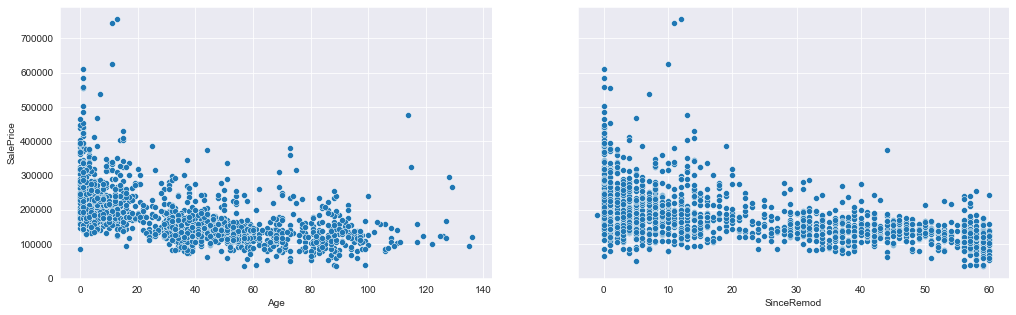

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5), sharey = True)
sns.scatterplot(data = df_time, x = 'Age', y = 'SalePrice', ax = ax[0])
sns.scatterplot(data = df_time, x = 'SinceRemod', y = 'SalePrice', ax = ax[1])

Unsurprisingly, newer houses or newly refurbished houses are more expensive than older houses.

## 3. Dataframe Finalization

##### Train Data Set

In [27]:
cont_variables = ['GrLivArea', 'AvgRoomSize', 'TotBaths', 'GarageCars', 'TotalBsmtSF']
binary_variables = ['HasPool', 'HasPorch', 'HasAir', 'IsPaved']
ord_variables = ['OverallQual', 'ExterQual', 'PavedDrive', 'KitchenQual', 'HeatingQC']
cat_variables = ['MSZoning', 'Foundation', 'RoofStyle', 'Electrical']
time_variables = ['SinceRemod']

df_train = pd.DataFrame(index = df.index)
df_train['SalePrice'] = df['SalePrice']

for var in cont_variables:
    df_train[var] = df_cont[var]
    
for var in binary_variables:
    df_train[var] = df_binary[var]

for var in ord_variables:
    df_train[var] = df_ordinal[var]
    
for var in cat_variables:
    df_train[var] = df_cat[var]
    
df_train['SinceRemod'] = df_time['SinceRemod']
df_train['Electrical'].fillna("SBrkr", inplace=True)

##### Test Data Set

In [29]:
df_test = pd.read_csv(f'{data_dir}test.csv', index_col = 'Id')
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [30]:
df_test.isna().sum()

MSSubClass          0
MSZoning            4
LotFrontage       227
LotArea             0
Street              0
Alley            1352
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         16
MasVnrArea         15
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           44
BsmtCond           45
BsmtExposure       44
BsmtFinType1       42
BsmtFinSF1          1
BsmtFinType2       42
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

In [31]:
df_test.loc[df_test['PoolArea'] > 0, 'HasPool'] = 1
df_test.loc[df_test['PoolArea'] == 0, 'HasPool'] = 0

df_test.loc[(df_test['ScreenPorch'] > 0) | (df_test['3SsnPorch'] > 0) | (df_test['EnclosedPorch'] > 0) | (df_test['OpenPorchSF']) | (df_test['WoodDeckSF'] > 0), 'HasPorch'] = 1
df_test.loc[df_test['HasPorch'] != 1, 'HasPorch'] = 0

df_test.loc[df_test['Street'] == 'Pave', 'IsPaved'] = 1
df_test.loc[df_test['Street'] != 'Pave', 'IsPaved'] = 0

df_test.loc[df_test['CentralAir'] == 'Y', 'HasAir'] = 1
df_test.loc[df_test['CentralAir'] != 'Y', 'HasAir'] = 0

df_test['SinceRemod'] = df_test['YrSold'] - df_test['YearRemodAdd']
df_test['AvgRoomSize'] = df_test['GrLivArea'] / df_test['TotRmsAbvGrd']
df_test['TotBaths'] = df_test['FullBath'] + (df_test['HalfBath'] / 2)

columns = ['GrLivArea', 'AvgRoomSize', 'TotBaths', 'GarageCars', 'TotalBsmtSF', 'HasPool', 'HasPorch', 
           'HasAir', 'IsPaved', 'OverallQual', 'ExterQual', 'PavedDrive', 'KitchenQual', 'HeatingQC',
           'MSZoning', 'Foundation', 'RoofStyle', 'Electrical', 'SinceRemod']

df_test = df_test[columns]

In [32]:
df_test.isna().sum()

GrLivArea      0
AvgRoomSize    0
TotBaths       0
GarageCars     1
TotalBsmtSF    1
HasPool        0
HasPorch       0
HasAir         0
IsPaved        0
OverallQual    0
ExterQual      0
PavedDrive     0
KitchenQual    1
HeatingQC      0
MSZoning       4
Foundation     0
RoofStyle      0
Electrical     0
SinceRemod     0
dtype: int64

In [33]:
### Fill missing values on test data set
df_test['GarageCars'].fillna(0, inplace=True)
df_test['TotalBsmtSF'].fillna(0, inplace=True)
df_test['KitchenQual'].fillna('TA', inplace=True)
df_test['MSZoning'].fillna('RL', inplace=True)

In [34]:
### Split data for training
X = df_train[columns]
y = df_train['SalePrice']

## 4. Column Transformation

In [35]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [36]:
cont_columns = ['GrLivArea', 'AvgRoomSize', 'TotBaths', 'SinceRemod', 'GarageCars', 'TotalBsmtSF']
cat_columns = ['MSZoning', 'Foundation', 'RoofStyle', 'Electrical']
ord_columns = ['OverallQual', 'ExterQual', 'PavedDrive', 'KitchenQual', 'HeatingQC']

column_transformer = make_column_transformer(
                            (StandardScaler(), cont_columns),
                            (OneHotEncoder(handle_unknown='ignore'), cat_columns),
                            (OrdinalEncoder(categories= [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ['Fa', 'TA', 'Gd', 'Ex'],
                                                         ['N', 'P', 'Y'], ['Fa', 'TA', 'Gd', 'Ex'],
                                                         ['Po', 'Fa', 'TA', 'Gd', 'Ex']]), ord_columns),
                            remainder = 'passthrough')

## 5. Model Testing

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

##### Linear Regressor

In [38]:
lin = LinearRegression()

pipe = make_pipeline(column_transformer, lin)
score = -1 * cross_val_score(pipe, X, y, cv = 10, scoring= 'neg_mean_absolute_error').mean()
print(f'Linear Regression: {score}')

Linear Regression: 23411.06820962541


##### Bayesian Ridge Regressor

In [39]:
bay = BayesianRidge()

pipe = make_pipeline(column_transformer, bay)

param_grid = {'bayesianridge__n_iter' : [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 50, 100, 300]}
grid = GridSearchCV(pipe, param_grid, cv = 10, scoring = 'neg_mean_absolute_error')
grid.fit(X, y)

print(f'Bayesian Ridge: {-1 * grid.best_score_}')
print(grid.best_params_)

Bayesian Ridge: 23206.699877383355
{'bayesianridge__n_iter': 12}


##### Decision Tree Regressor

In [48]:
dtree = DecisionTreeRegressor()

pipe = make_pipeline(column_transformer, dtree)

param_grid = {'decisiontreeregressor__criterion' : ['mse', 'friedman_mse', 'mae', 'poisson'], 
              'decisiontreeregressor__max_leaf_nodes' : [1750, 1775, 1800, 1825, 1850, 1875, 1900]}

grid = GridSearchCV(pipe, param_grid, cv=10, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print(f'Decision Tree: {-1 * grid.best_score_}')
print(grid.best_params_)

Decision Tree: 26887.368378995434
{'decisiontreeregressor__criterion': 'friedman_mse', 'decisiontreeregressor__max_leaf_nodes': 1825}


##### Random Forest Regressor

In [51]:
rf = RandomForestRegressor()

pipe = make_pipeline(column_transformer, rf)
param_grid = {'randomforestregressor__n_estimators' : [110, 115, 120, 125, 130, 135, 140, 145],
                'randomforestregressor__max_depth' : [5, 10, 15, 20, 25]}

grid = GridSearchCV(pipe, param_grid, cv = 10, scoring = 'neg_mean_absolute_error')
grid.fit(X, y)

print(f'Random Forest: {-1 * grid.best_score_}')
print(grid.best_params_)

Random Forest: 19230.681563294544
{'randomforestregressor__max_depth': 20, 'randomforestregressor__n_estimators': 125}


##### Catboost Regressor

In [55]:
cat = CatBoostRegressor(verbose=False)

pipe = make_pipeline(column_transformer, cat)

param_dist = {'catboostregressor__iterations' : [700, 800, 900, 1000],
                'catboostregressor__learning_rate': [0.1, 0.05, 0.01, 0.005],
                'catboostregressor__depth' : [4, 5, 6, 7, 10],
                'catboostregressor__l2_leaf_reg' : [5, 6, 9, 11, 15, 20]}

rand = RandomizedSearchCV(pipe, param_dist, cv = 10, scoring = 'neg_mean_absolute_error', n_iter = 20)
rand.fit(X, y)

print(f'Catboost Regressor: {-1 * rand.best_score_}')
print(rand.best_params_)

Catboost Regressor: 18506.04188525609
{'catboostregressor__learning_rate': 0.05, 'catboostregressor__l2_leaf_reg': 6, 'catboostregressor__iterations': 800, 'catboostregressor__depth': 4}


## 6. Predict with Best Model

In [57]:
best_model = CatBoostRegressor(learning_rate=0.05, l2_leaf_reg=6, iterations=900, depth=4, verbose=False)
pipe = make_pipeline(column_transformer, best_model)
pipe.fit(X, y)
predictions = pipe.predict(df_test)

## 7. Output Predictions

In [59]:
output = pd.DataFrame({'Id': df_test.index,
                       'SalePrice': predictions})

output.to_csv('submission.csv', index = False)

print('finished')

finished
